#### Описание.

Это копия демонстрационного ноутбука из репозитория granite-tsfm, который я скачал локально.

Прогон на датасете [IOPS](https://arxiv.org/html/2402.10802v1)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tsfm_public.models.tspulse.modeling_tspulse import TSPulseForReconstruction
from tsfm_public.toolkit.ad_helpers import AnomalyScoreMethods
from tsfm_public.toolkit.time_series_anomaly_detection_pipeline import TimeSeriesAnomalyDetectionPipeline

c:\Users\ASUS\.pyenv\pyenv-win\versions\3.11.4\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# %pip install hf_xet

# Example Datafile

Data instance from IOPS dataset ([Paper](https://arxiv.org/html/2402.10802v1)). The data example is a part of the IOPS dataset.

The IOPS data set is an anonymized dataset with performance indicators that reflect the scale, quality of web services, and health status of a machine.



In [4]:
data_path = "https://huggingface.co/datasets/AutonLab/Timeseries-PILE/resolve/main/anomaly_detection/TSB-UAD-Public/IOPS/KPI-4d2af31a-9916-3d9f-8a8e-8a268a48c095.test.out"


## Helper Functions for Data Loading and Processing

**NB**: data from AutonLab repo loads only with VPN !!!!

`load_data` loads the large dataset in chunks.

`attach_timestamp_column` current pipeline expects a timestamp column in the input. The IOPS dataset does not have an explicit time column specified. This helper function attach a dummy timestamp column to the dataset.



In [5]:
def load_data(file_path: str, max_length: int, min_length: int):
    data = []
    extra_args = {}
    if file_path.endswith("gz"):
        extra_args["compression"] = "gzip"
    for chunk in pd.read_csv(file_path, header=None, sep=",", chunksize=max_length, *extra_args):
        if (chunk is None) or (chunk.ndim != 2):
            break
        chunk.columns = ["x", "y"]
        chunk["x"] = chunk.x.interpolate(method="cubic").ffill().bfill()
        chunk["y"] = chunk.y.ffill().bfill()
        if chunk.shape[0] > min_length:
            data.append(chunk)
        elif len(data) > 0:
            data[-1] = pd.concat([data[-1], chunk], axis=0)
    return data


def attach_timestamp_column(
    df: pd.DataFrame, time_col: str = "timestamp", freq: str = "D", start_date: str = "2022-01-01"
):
    n = df.shape[0]
    if time_col not in df:
        df[time_col] = pd.date_range(start_date, freq=freq, periods=n)
    return df

In [6]:
max_length, min_length = 5_000, 2_000

data = load_data(data_path, max_length, min_length)

## Loading ZeroShort TSPulseReconstruction Model

In [7]:
path_to_tspulse_model = "ibm-granite/granite-timeseries-tspulse-r1"
zeroshot_model = TSPulseForReconstruction.from_pretrained(
    path_to_tspulse_model,
    num_input_channels=1,
    revision="main",
    mask_type="user",
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
c:\Users\ASUS\.pyenv\pyenv-win\versions\3.11.4\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ASUS\.cache\huggingface\hub\models--ibm-granite--granite-timeseries-tspulse-r1. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate d

## Instantiating pipeline

In [8]:
pipeline = TimeSeriesAnomalyDetectionPipeline(
    zeroshot_model,
    timestamp_column="timestamp",
    target_columns=["x"],
    prediction_mode=[
        AnomalyScoreMethods.TIME_RECONSTRUCTION.value,
        AnomalyScoreMethods.FREQUENCY_RECONSTRUCTION.value,
    ],
    aggregation_length=64,
    aggr_function="max",
    smoothing_length=8,
    least_significant_scale=0.01,
    least_significant_score=0.1,
)

Device set to use cpu


In [9]:
validation_df = attach_timestamp_column(data[10], time_col="timestamp", freq="s")
validation_df.head()

,x,y,timestamp
50000,5.00,0,2022-01-01 00:00:00
50001,4.80,0,2022-01-01 00:00:01
50002,5.25,0,2022-01-01 00:00:02
50003,4.95,0,2022-01-01 00:00:03
50004,5.05,0,2022-01-01 00:00:04


## Computing Anomaly Score With Anomaly Pipeline 

Comment from Seva: Time estimator does not work properly.

In [10]:
%time
result = pipeline(validation_df, batch_size=256, predictive_score_smoothing=False)

CPU times: total: 0 ns
Wall time: 0 ns


## Plotting the score vs TRUE Anomaly Marks

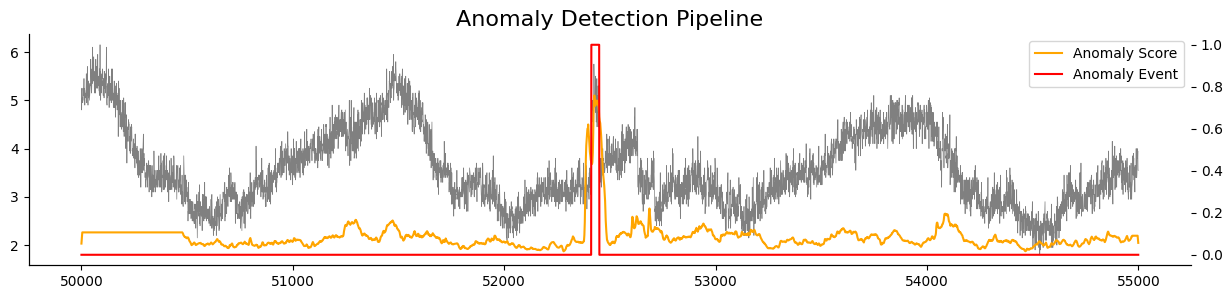

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
ax2 = ax.twinx()
result.x.plot(ax=ax, color="gray", linewidth=0.5)
result.anomaly_score.plot(ax=ax2, color="orange", label="Anomaly Score")
result.y.plot(ax=ax2, color="red", label="Anomaly Event")
ax2.legend()
# ax2.set_yticks([])
ax.set_title("Anomaly Detection Pipeline", fontsize=16)
for s in ["top", "right"]:
    ax.spines[s].set_visible(False)
    ax2.spines[s].set_visible(False)

Anomlay result attaches anomaly scores as a new column. By default the scores are scaled between (0-1)

In [12]:
result.head(5)

,x,y,timestamp,anomaly_score
50000,5.00,0,2022-01-01 00:00:00,0.053295
50001,4.80,0,2022-01-01 00:00:01,0.066619
50002,5.25,0,2022-01-01 00:00:02,0.079943
50003,4.95,0,2022-01-01 00:00:03,0.093267
50004,5.05,0,2022-01-01 00:00:04,0.106591


## Threshold Based Anomaly Marking

In [13]:
anomaly_threshold = 0.6
result["detections"] = (result["anomaly_score"] > anomaly_threshold).astype(float)

result.head()

,x,y,timestamp,anomaly_score,detections
50000,5.00,0,2022-01-01 00:00:00,0.053295,0.0
50001,4.80,0,2022-01-01 00:00:01,0.066619,0.0
50002,5.25,0,2022-01-01 00:00:02,0.079943,0.0
50003,4.95,0,2022-01-01 00:00:03,0.093267,0.0
50004,5.05,0,2022-01-01 00:00:04,0.106591,0.0


## Computing F1 Score for detection

In [14]:
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score


matrix = confusion_matrix(result["y"].values, result["detections"].values)
matrix = pd.DataFrame(
    matrix,
    columns=["Predicted Anomaly: No", "Predicted Anomaly: Yes"],
    index=["True Anomaly: No", "True Anomaly: Yes"],
)

f_score = f1_score(result["y"].values, result["detections"].values, average="binary")

display(f"F1 score: {f_score:.2f}")
display(matrix)

'F1 score: 0.74'

,Predicted Anomaly: No,Predicted Anomaly: Yes
True Anomaly: No,4952,10
True Anomaly: Yes,10,28


## TSPulse supports multiple prediction modes

In [16]:
prediction_modes = [
    AnomalyScoreMethods.PREDICTIVE.value,
    AnomalyScoreMethods.TIME_RECONSTRUCTION.value,
    AnomalyScoreMethods.FREQUENCY_RECONSTRUCTION.value,
]

prediction_modes.append(prediction_modes.copy())

display(f"All Prediction Modes: {prediction_modes}")

"All Prediction Modes: ['forecast', 'time', 'fft', ['forecast', 'time', 'fft']]"

## Mode Triangulation

Mode triangulation uses a validation data to identify best prediction mode for anomaly detection in a given dataset.

In [17]:
f_scores = []

for mode in prediction_modes:
    if not isinstance(mode, list):
        mode = [mode]
    pipeline = TimeSeriesAnomalyDetectionPipeline(
        zeroshot_model,
        timestamp_column="timestamp",
        target_columns=["x"],
        prediction_mode=mode,
        aggr_win_size=64,
        aggr_function="max",
        smoothing_window_size=16,
        least_significant_scale=0.01,
        least_significant_score=0.1,
    )
    result = pipeline(validation_df, batch_size=256, predictive_score_smoothing=True)
    result["detections"] = (result["anomaly_score"] > anomaly_threshold).astype(float)
    f_score = f1_score(result["y"].values, result["detections"].values, average="binary")
    f_scores.append(f_score)

Device set to use cpu
Device set to use cpu
Device set to use cpu
Device set to use cpu


Best mode selection is metric or KPI driven. Here we use F1 Score for mode selection

In [19]:
selected_mode = prediction_modes[np.argmax(f_scores)]
print(f"Best Prediction mode for train set: {selected_mode}")

Best Prediction mode for train set: ['forecast', 'time', 'fft']


## Test Dataset

In [20]:
test_df = attach_timestamp_column(data[15], time_col="timestamp", freq="s")
test_df.head()

,x,y,timestamp
75000,5.05,0,2022-01-01 00:00:00
75001,5.10,0,2022-01-01 00:00:01
75002,4.95,0,2022-01-01 00:00:02
75003,5.65,0,2022-01-01 00:00:03
75004,5.05,0,2022-01-01 00:00:04


## Executing pipeline With Best Prediction Mode

In [21]:
best_pipeline = TimeSeriesAnomalyDetectionPipeline(
    zeroshot_model,
    timestamp_column="timestamp",
    target_columns=["x"],
    prediction_mode=selected_mode,
    aggr_win_size=64,
    aggr_function="max",
    smoothing_window_size=16,
    least_significant_scale=0.01,
    least_significant_score=0.1,
)

Device set to use cpu


In [22]:
%time
result_test = pipeline(test_df, batch_size=256, predictive_score_smoothing=True)

CPU times: total: 0 ns
Wall time: 0 ns


In [23]:
result_test.head()

,x,y,timestamp,anomaly_score
75000,5.05,0,2022-01-01 00:00:00,0.021878
75001,5.10,0,2022-01-01 00:00:01,0.027348
75002,4.95,0,2022-01-01 00:00:02,0.032817
75003,5.65,0,2022-01-01 00:00:03,0.038287
75004,5.05,0,2022-01-01 00:00:04,0.043757


## Plotting Scores For Test Data Split

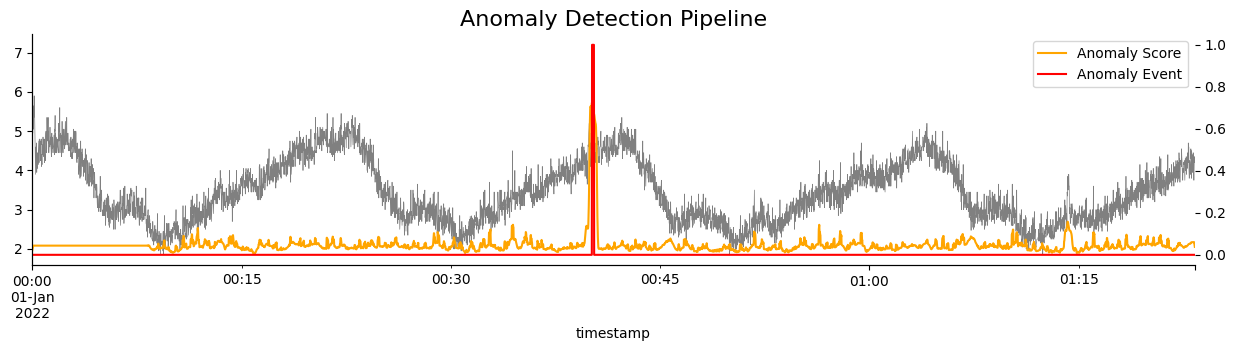

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
ax2 = ax.twinx()
result_test.set_index("timestamp").x.plot(ax=ax, color="gray", linewidth=0.5)
result_test.set_index("timestamp").anomaly_score.plot(ax=ax2, color="orange", label="Anomaly Score")
result_test.set_index("timestamp").y.plot(ax=ax2, color="red", label="Anomaly Event")
ax2.legend()
# ax2.set_yticks([])
ax.set_title("Anomaly Detection Pipeline", fontsize=16)
for s in ["top", "right"]:
    ax.spines[s].set_visible(False)
    ax2.spines[s].set_visible(False)